# Chain

Review - We built a simple graph with nodes, normal edges and conditional edges.

Goals Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state Using chat models in graph nodes Binding tools to our chat model Executing tool calls in graph nodes.

In [24]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [25]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [26]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="gemma2-9b-it")
result=llm.invoke(messages)
result

AIMessage(content="That's a wonderful choice! Orcas are truly majestic creatures.  \n\nThe best place to see orcas in the US is generally considered to be **the Pacific Northwest, specifically the waters off the coasts of Washington state and British Columbia, Canada.** \n\nHere's why:\n\n* **Abundant Population:** This region is home to a large and thriving population of orcas, including several distinct ecotypes (subspecies) with unique hunting strategies and social structures.\n* **Whale Watching Tours:**  Many reputable whale watching tour operators operate in the San Juan Islands of Washington state, offering excellent opportunities to observe orcas in their natural habitat.\n* **Resident Pods:**  Several resident orca pods frequent these waters year-round, making sightings more likely. These pods are known for their close family bonds and complex social interactions.\n\n**Specific Locations:**\n\n* **San Juan Islands, Washington:**  This archipelago is a prime spot for orca viewi

In [27]:
def add(a:int, b:int)-> int:
    """
    Add a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a+b

In [28]:
llm_with_tools=llm.bind_tools([add])

In [29]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0t63', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 982, 'total_tokens': 1069, 'completion_time': 0.158181818, 'prompt_time': 0.042659053, 'queue_time': 0.282726229, 'total_time': 0.200840871}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-245069dd-c7cb-49eb-bf0f-a1aaef538c11-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_0t63', 'type': 'tool_call'}], usage_metadata={'input_tokens': 982, 'output_tokens': 87, 'total_tokens': 1069})

In [30]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_0t63',
  'type': 'tool_call'}]

In [31]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [32]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                HumanMessage(content="I'm looking for information on generative ai.", name="Deepak")
                ]
#New message to add
new_message= AIMessage(content="Sure, I can help with that. What specific are you interested in?", name="Model")
add_messages(initial_message, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='beba1f17-d4bd-4b1e-a9da-6b548976850a'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Deepak', id='85441580-c186-4e36-9fef-9215d6db0994'),
 AIMessage(content='Sure, I can help with that. What specific are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='b873c61b-80fa-434b-8e48-c74d69a2616e')]

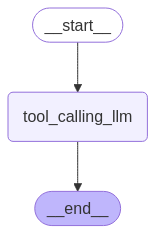

In [33]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

#Node
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages=graph.invoke({"messages":HumanMessage(content="What is 3 add 2?")})
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 3 add 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_b74q)
 Call ID: call_b74q
  Args:
    a: 3
    b: 2


In [35]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

# Tools

Tools are useful whenever you want a model to interact with external systems.

External systems(e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required Input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, It will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any python function into ChatModel.bin_tools(function).




In [36]:
llm.invoke("Hello")

AIMessage(content='Hello! 👋  What can I do for you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.001900566, 'queue_time': 0.24114196400000001, 'total_time': 0.030991475}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-2e5381f7-8302-4345-9739-fefc03789157-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})

In [37]:
llm_with_tools = llm.bind_tools([multiply, add])

In [38]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

In [39]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [44]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply,add]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
#builder.add_edge("tool2", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [43]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2 and add 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2 and add 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_wntc)
 Call ID: call_wntc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
